# Demonstrating PERCIVAL

See "Learning Bayes' theorem with a neural network for gravitational-wave inference" by A. J. K. Chua and M. Vallisneri ([arXiv:1904.05355](http://www.arxiv.org/abs/1904.05355)).

*Michele and Alvin, 9/23/2019*

## Install

In [ ]:
!pip install git+https://github.com/vallis/TrueBayes.git

## Imports

In [2]:
import os
import math
import imp

In [3]:
import numpy as np
import matplotlib.pyplot as pp

%matplotlib inline

In [9]:
import torch

In [5]:
import truebayes.network
import truebayes.geometry
import truebayes.roman
import truebayes.loss
import truebayes.like
import truebayes.plot

In [19]:
imp.reload(truebayes.network)
imp.reload(truebayes.loss)
imp.reload(truebayes.geometry)
imp.reload(truebayes.roman)
imp.reload(truebayes.like)
imp.reload(truebayes.plot)

<module 'truebayes.plot' from '/Users/vallis/Documents/lisanew/truebayes/truebayes/plot.py'>

## 4D ROMAN family

In [0]:
Net_roman_G4 = truebayes.network.makenet([241*2] + [1024] * 8 + [3*3], softmax=False)

nrg4 = Net_roman_G4()
nrg4.load_state_dict(torch.load('/content/gdrive/My Drive/Colab Notebooks/data/Mc_l1024x8_g3_SNR8-16_4d_temp.pt'))
nrg4.eval();

In [0]:
mutest4 = truebayes.roman.syntrain(snr=[8,16], size=5000, varx='Mc',
                                   region=[[0.26,0.47], [0.2,0.25], [-1,1], [-1,1]], noise=1, varall=True, seed=2)

In [0]:
Mc = mutest4[0][:,0]
nu = mutest4[0][:,1]
chi1 = mutest4[0][:,2]
chi2 = mutest4[0][:,3]

snr = mutest4[0][:,4]

idx = np.argsort(Mc)

In [0]:
likeset4 = lambda: truebayes.roman.syntrain(snr=[8,16], size=100000, varx='Mc',
                                            region=[[0.26,0.47], [0.2,0.25], [-1,1], [-1,1]], noise=0)

In [0]:
%%time
lm4, le4 = truebayes.like.synmean(mutest4[2], likeset4, iterations=100*1000000)

CPU times: user 5min 7s, sys: 4min 12s, total: 9min 19s
Wall time: 9min 21s


In [0]:
nm4, ne4 = truebayes.loss.netmeanGn(mutest4[2], net=nrg4)

In [0]:
np.savetxt('/content/gdrive/My Drive/Colab Notebooks/data/pars_SNR8-16_4d.txt',mutest4[0])

np.savetxt('/content/gdrive/My Drive/Colab Notebooks/data/likemeans_SNR8-16_4d-means.txt',lm4)
np.savetxt('/content/gdrive/My Drive/Colab Notebooks/data/likemeans_SNR8-16_4d-stderrs.txt',le4)

np.savetxt('/content/gdrive/My Drive/Colab Notebooks/data/netmeans-1024_SNR8-16_4d-means.txt',nm4)
np.savetxt('/content/gdrive/My Drive/Colab Notebooks/data/netmeans-1024_SNR8-16_4d-stderr.txt',ne4)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


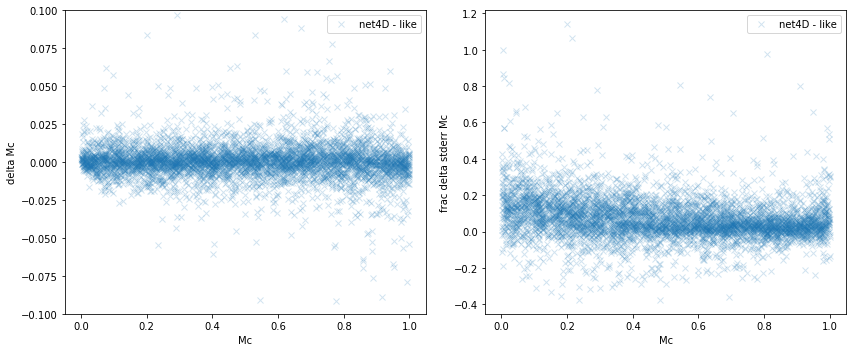

In [0]:
pp.figure(figsize=(12,5))

idx = np.argsort(Mc)

pp.subplot(1,2,1)
pp.plot(Mc[idx], nm4[idx]  - lm4[idx], 'x', label='net4D - like', alpha=0.2)
# pp.plot(Mc[idx], nm2b[idx,0] - lm2[idx,0], '.', label='net2Db - like', alpha=0.2)
pp.xlabel('Mc'); pp.ylabel('delta Mc'); pp.legend()
pp.axis(ymin=-0.1,ymax=0.1)

pp.subplot(1,2,2)
pp.plot(Mc[idx], np.log10(ne4[idx]/le4[idx]), 'x', label='net4D - like', alpha=0.2)
# pp.plot(Mc[idx], (ne2b[idx,0] - le2[idx,0])/le2[idx,0], '.', label='net2Db - like', alpha=0.2)
pp.xlabel('Mc'); pp.ylabel('frac delta stderr Mc'); pp.legend()

pp.tight_layout()

## 2D ROMAN family (no spins)

### Set up networks

We get single-precision by default; `softmax=True` is required for Gaussian-mixture posteriors.

Go into eval mode to avoid torch working backpropagation, etc.

In [6]:
Net_roman_G = truebayes.network.makenet([241*2] + [256] * 8 + [1*3], softmax=True)

nrg = Net_roman_G()

In [ ]:
nrg.load_state_dict(torch.load('/content/gdrive/My Drive/Colab Notebooks/data/Mc_l256x8_g1_SNR8-16_2d.pt'))
nrg.eval();

In [0]:
nrg_nu = Net_roman_G()
nrg_nu.load_state_dict(torch.load('/content/gdrive/My Drive/Colab Notebooks/data/nu_l256x8_g1_SNR8-16_2d.pt'))
nrg_nu.eval();

In [0]:
# Net_roman_G2 = truebayes.network.makenet([241*2] + [512] * 8 + [1*6], softmax=False)
Net_roman_G2 = truebayes.network.makenet([241*2] + [1024] * 8 + [1*6], softmax=False)

nrg2 = Net_roman_G2()
# nrg2.load_state_dict(torch.load('/content/gdrive/My Drive/Colab Notebooks/data/Mc-nu_l512x8_g1_SNR8-16_2d.pt'))
nrg2.load_state_dict(torch.load('/content/gdrive/My Drive/Colab Notebooks/data/Mc-nu_l1024x8_g1_SNR8-16_2d.pt'))
nrg2.eval();

This is how we would train the 1D network... except Alvin did it for us.

Setup a training-set factory over a reduced Mc-nu region, uniformly distributed in SNR, which will produce batches of 100000. Noise is set to 1 by default, as appropriate for training.

Specifying `varx` as `'Mc'` returns parameter and indicator arrays appropriate for 1D training. Specifying the region with two intervals will set the remaining parameters to zero.

In [7]:
trainingset = lambda: truebayes.roman.syntrain(snr=[8,16], size=100000, varx='Mc', region=[[0.26,0.47], [0.2,0.25]])

In [10]:
print(torch.__config__.parallel_info())

ATen/Parallel:
	at::get_num_threads() : 1
	at::get_num_interop_threads() : 10
OpenMP not found
MKL not found
Intel(R) MKL-DNN v0.18.1 (Git Hash 7de7e5d02bf687f971e7668963649728356e0c20)
std::thread::hardware_concurrency() : 20
Environment variables:
	OMP_NUM_THREADS : [not set]
	MKL_NUM_THREADS : [not set]
ATen parallel backend: OpenMP



In [13]:
print(torch.__config__.show())

PyTorch built with:
  - GCC 4.2
  - clang 9.0.0
  - Intel(R) MKL-DNN v0.18.1 (Git Hash 7de7e5d02bf687f971e7668963649728356e0c20)
  - NNPACK is enabled
  - Build settings: BLAS=MKL, BUILD_NAMEDTENSOR=OFF, BUILD_TYPE=Release, CXX_FLAGS= -Wno-deprecated -fvisibility-inlines-hidden -Wno-deprecated-declarations -DUSE_FBGEMM -DUSE_QNNPACK -O2 -fPIC -Wno-narrowing -Wall -Wextra -Wno-missing-field-initializers -Wno-type-limits -Wno-array-bounds -Wno-unknown-pragmas -Wno-sign-compare -Wno-unused-parameter -Wno-unused-variable -Wno-unused-function -Wno-unused-result -Wno-strict-overflow -Wno-strict-aliasing -Wno-error=deprecated-declarations -Wno-error=pedantic -Wno-error=redundant-decls -Wno-error=old-style-cast -Wno-invalid-partial-specialization -Wno-typedef-redefinition -Wno-unknown-warning-option -Wno-unused-private-field -Wno-inconsistent-missing-override -Wno-aligned-allocation-unavailable -Wno-c++14-extensions -Wno-constexpr-not-const -Wno-missing-braces -Qunused-arguments -fcolor-diagno

In [11]:
%%time
truebayes.roman.syntrainer(nrg, trainingset, lossfunction=truebayes.loss.kllossGn,
                           iterations=1000000, initstep=1e-4, finalv=1e-8)

0 0.33789682388305664 
One epoch = 7.3 seconds.


KeyboardInterrupt: 

### Setup test examples and template factories

We need to match the parameter region where the training happened. Giving `varall=True` means setting `varx` has no effect other than on the indicator array, which we don't use.

In [0]:
mutest = truebayes.roman.syntrain(snr=[8,16], size=5000, varx='Mc', region=[[0.26,0.47], [0.2,0.25]], noise=1, varall=True, seed=2)

In [0]:
Mc = mutest[0][:,0]
nu = mutest[0][:,1]
snr = mutest[0][:,4]

idx = np.argsort(Mc)

In [0]:
# np.savez('/content/gdrive/My Drive/Colab Notebooks/data/truth_SNR8-16_2d.npz', mutest[0])
# np.savetxt('/content/gdrive/My Drive/Colab Notebooks/data/truth_SNR8-16_2d.txt', mutest[0])

In [0]:
likeset = lambda: truebayes.roman.syntrain(snr=[8,16], size=100000, varx='Mc', region=[[0.26,0.47], [0.2,0.25]], noise=0)

In [0]:
likeset_nu = lambda: truebayes.roman.syntrain(snr=[8,16], size=100000, varx='nu', region=[[0.26,0.47], [0.2,0.25]], noise=0)

In [0]:
likeset_2 = lambda: truebayes.roman.syntrain(snr=[8,16], size=100000, varx=['Mc','nu'], region=[[0.26,0.47], [0.2,0.25]], noise=0)

### Plot 2-D histogram from 2-D network

In [0]:
%%time
sl2 = truebayes.like.synlike(mutest[2][:24,:], likeset_2, iterations=10000000)

CPU times: user 4min 13s, sys: 20.5 s, total: 4min 33s
Wall time: 4min 34s


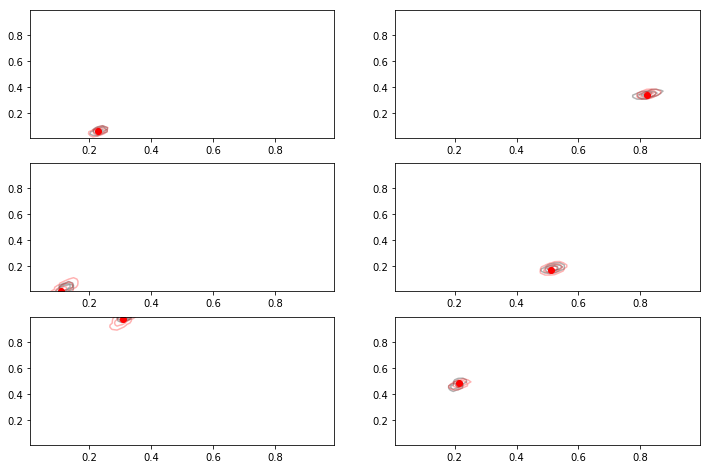

In [0]:
truebayes.plot.makecontour(*mutest, net=nrg2, like=sl2, istart=6)

### Plot 1-D histograms from 1-D and 2-D networks

One minute for 512 x 10,000,000 

In [0]:
%%time
sl = truebayes.like.synlike(mutest[2][:24,:], likeset, iterations=10000000)

CPU times: user 34.3 s, sys: 21.4 s, total: 55.7 s
Wall time: 55.8 s


In [0]:
%%time
sl_nu = truebayes.like.synlike(mutest[2][:24,:], likeset_nu, iterations=10000000)

CPU times: user 34.4 s, sys: 22.2 s, total: 56.6 s
Wall time: 56.7 s


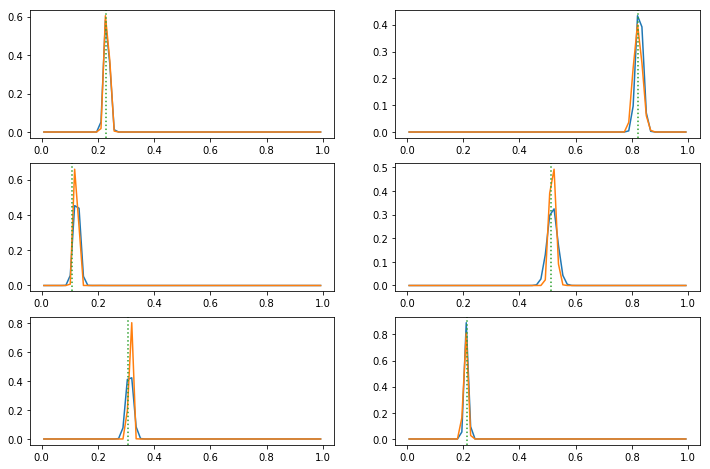

In [0]:
truebayes.plot.plotgauss(*mutest, net=nrg, varx='Mc', like=sl, istart=6)

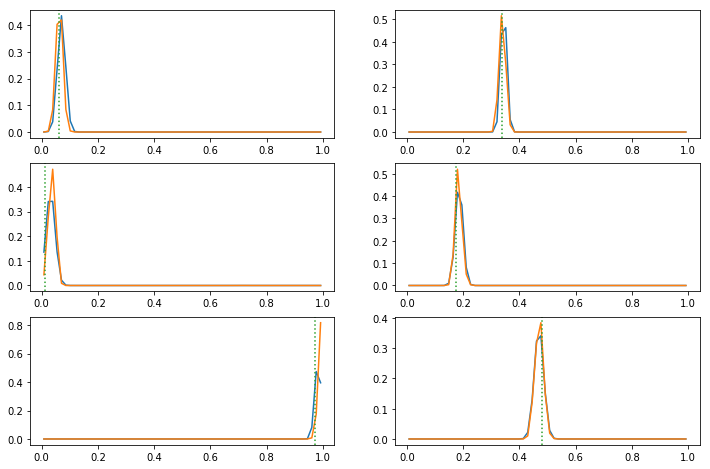

In [0]:
truebayes.plot.plotgauss(*mutest, net=nrg_nu, varx='nu', like=sl_nu, istart=6)

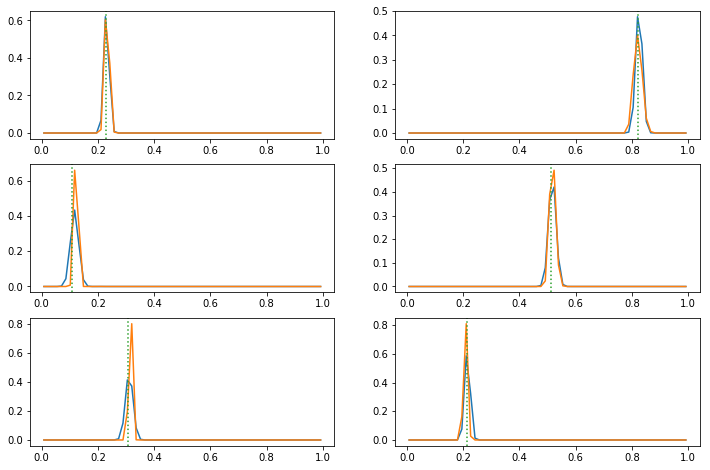

In [0]:
truebayes.plot.plotgauss(*mutest, net=nrg2, varx='Mc', like=sl, twodim=True, istart=6)

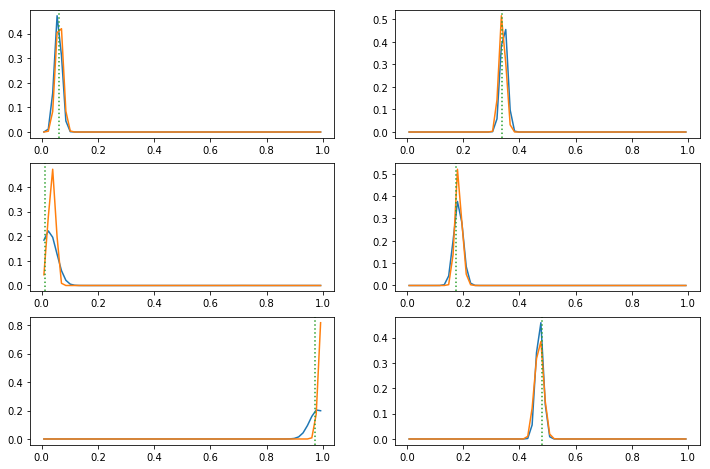

In [0]:
truebayes.plot.plotgauss(*mutest, net=nrg2, varx='nu', like=sl_nu, twodim=True, istart=6)

### Compute 1D and 2D means

Conditional means and std errors from "real" posteriors.

In [0]:
%%time
lm, le = truebayes.like.synmean(mutest[2], likeset, iterations=10000000)

CPU times: user 58.7 s, sys: 40.7 s, total: 1min 39s
Wall time: 1min 39s


In [0]:
%%time
lm_nu, le_nu  = truebayes.like.synmean(mutest[2], likeset_nu, iterations=10000000)

CPU times: user 58.4 s, sys: 40.8 s, total: 1min 39s
Wall time: 1min 39s


Much slower... maybe because we're making indicator arrays?

In [0]:
%%time
lm2, le2, lc2 = truebayes.like.synmean(mutest[2], likeset_2, iterations=10000000)

CPU times: user 3min 1s, sys: 45.5 s, total: 3min 46s
Wall time: 3min 46s


In [0]:
npz = np.load('/content/gdrive/My Drive/Colab Notebooks/data/likemeans_SNR8-16_2d.npz')
lm2, le2, lc2 = list(npz.values())

In [0]:
# np.savez('/content/gdrive/My Drive/Colab Notebooks/data/likemeans_SNR8-16_2d.npz',lm2,le2,lc2)
# np.savetxt('/content/gdrive/My Drive/Colab Notebooks/data/likemeans_SNR8-16_2d-means.txt',lm2)
# np.savetxt('/content/gdrive/My Drive/Colab Notebooks/data/likemeans_SNR8-16_2d-stderrs.txt',le2)
# np.savetxt('/content/gdrive/My Drive/Colab Notebooks/data/likemeans_SNR8-16_2d-cov.txt',lc2)

In [13]:
%%time
lm2, le2, lc2 = truebayes.like.synmean(mutest[2], likeset_2, iterations=200 * 1000000)
np.savetxt('/content/gdrive/My Drive/Colab Notebooks/data/likemeans_SNR8-16_2d-means-2e8.txt',lm2)
np.savetxt('/content/gdrive/My Drive/Colab Notebooks/data/likemeans_SNR8-16_2d-stderrs-2e8.txt',le2)
np.savetxt('/content/gdrive/My Drive/Colab Notebooks/data/likemeans_SNR8-16_2d-cov-2e8.txt',lc2)

CPU times: user 39min 59s, sys: 7min 52s, total: 47min 52s
Wall time: 47min 54s


Network predictions

In [0]:
nm, ne = truebayes.loss.netmeanGn(mutest[2], net=nrg)

In [0]:
nm_nu, ne_nu = truebayes.loss.netmeanGn(mutest[2], net=nrg_nu)

In [0]:
nm2, ne2, nc2 = truebayes.loss.netmeanGn2(mutest[2], net=nrg2)

Newer network

In [0]:
nm2b, ne2b, nc2b = truebayes.loss.netmeanGn2(mutest[2], net=nrg2)

In [0]:
npz = np.load('/content/gdrive/My Drive/Colab Notebooks/data/netmeans_SNR8-16_2d.npz')
nm2, ne2, nc2 = list(npz.values())

In [0]:
# np.savez('/content/gdrive/My Drive/Colab Notebooks/data/netmeans_SNR8-16_1d-Mc.npz', nm, ne)
# np.savez('/content/gdrive/My Drive/Colab Notebooks/data/netmeans_SNR8-16_1d-nu.npz', nm_nu, ne_nu)
# np.savez('/content/gdrive/My Drive/Colab Notebooks/data/netmeans_SNR8-16_2d.npz', nm2, ne2, nc2)

In [0]:
np.savetxt('/content/gdrive/My Drive/Colab Notebooks/data/netmeans-1024_SNR8-16_2d-means.txt',nm2b)
np.savetxt('/content/gdrive/My Drive/Colab Notebooks/data/netmeans-1024_SNR8-16_2d-stderr.txt',ne2b)
np.savetxt('/content/gdrive/My Drive/Colab Notebooks/data/netmeans-1024_SNR8-16_2d-cov.txt',nc2b)

### Plots

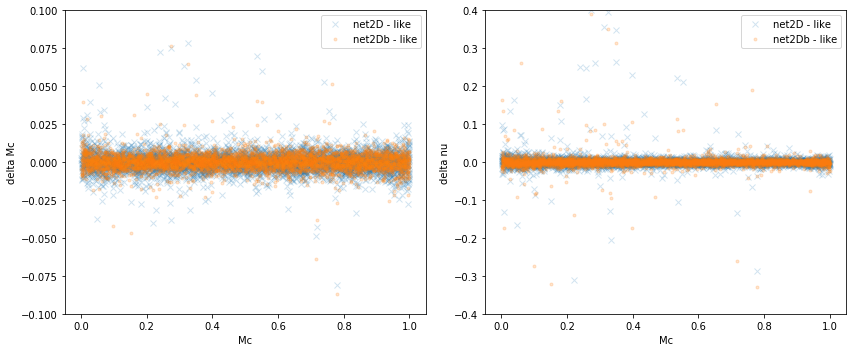

In [0]:
pp.figure(figsize=(12,5))

idx = np.argsort(Mc)

pp.subplot(1,2,1)
pp.plot(Mc[idx], nm2[idx,0]  - lm2[idx,0], 'x', label='net2D - like', alpha=0.2)
pp.plot(Mc[idx], nm2b[idx,0] - lm2[idx,0], '.', label='net2Db - like', alpha=0.2)
pp.xlabel('Mc'); pp.ylabel('delta Mc'); pp.legend()
pp.axis(ymin=-0.1,ymax=0.1)

pp.subplot(1,2,2)
pp.plot(Mc[idx], nm2[idx,1]  - lm2[idx,1], 'x', label='net2D - like', alpha=0.2)
pp.plot(Mc[idx], nm2b[idx,1] - lm2[idx,1], '.', label='net2Db - like', alpha=0.2)
pp.xlabel('Mc'); pp.ylabel('delta nu'); pp.legend()
pp.axis(ymin=-0.4,ymax=0.4)

pp.tight_layout()

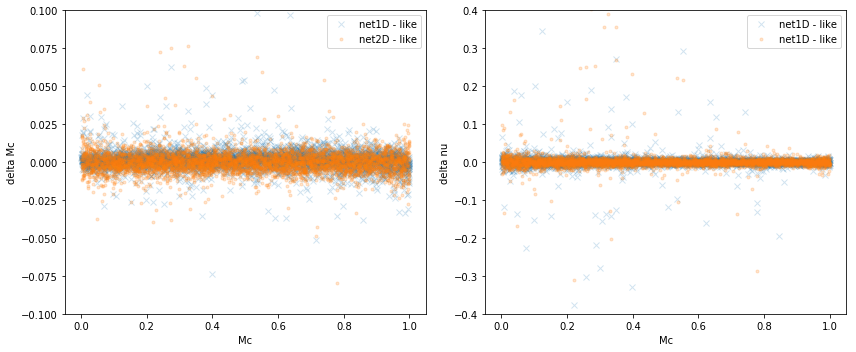

In [0]:
pp.figure(figsize=(12,5))

idx = np.argsort(Mc)

pp.subplot(1,2,1)
pp.plot(Mc[idx], nm[idx]    - lm[idx], 'x', label='net1D - like', alpha=0.2)
pp.plot(Mc[idx], nm2[idx,0] - lm[idx], '.', label='net2D - like', alpha=0.2)
pp.xlabel('Mc'); pp.ylabel('delta Mc'); pp.legend()
pp.axis(ymin=-0.1,ymax=0.1)

pp.subplot(1,2,2)
pp.plot(Mc[idx], nm_nu[idx] - lm_nu[idx], 'x', label='net1D - like', alpha=0.2)
pp.plot(Mc[idx], nm2[idx,1] - lm_nu[idx], '.', label='net1D - like', alpha=0.2)
pp.xlabel('Mc'); pp.ylabel('delta nu'); pp.legend()
pp.axis(ymin=-0.4,ymax=0.4)

pp.tight_layout()

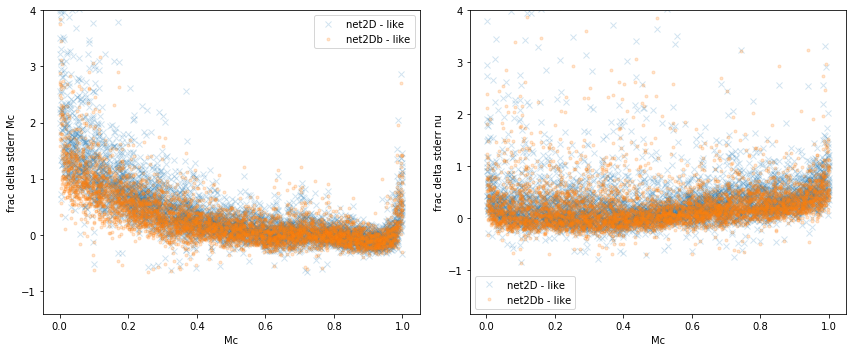

In [0]:
 pp.figure(figsize=(12,5))

idx = np.argsort(Mc)

pp.subplot(1,2,1)
pp.plot(Mc[idx], (ne2[idx,0]  - le2[idx,0])/le2[idx,0], 'x', label='net2D - like', alpha=0.2)
pp.plot(Mc[idx], (ne2b[idx,0] - le2[idx,0])/le2[idx,0], '.', label='net2Db - like', alpha=0.2)
pp.xlabel('Mc'); pp.ylabel('frac delta stderr Mc'); pp.legend(); pp.axis(ymax=4)

pp.subplot(1,2,2)
pp.plot(Mc[idx], (ne2[idx,1]  - le2[idx,1])/le2[idx,1], 'x', label='net2D - like', alpha=0.2)
pp.plot(Mc[idx], (ne2b[idx,1] - le2[idx,1])/le2[idx,1], '.', label='net2Db - like', alpha=0.2)
pp.xlabel('Mc'); pp.ylabel('frac delta stderr nu'); pp.legend(); pp.axis(ymax=4)

pp.tight_layout()

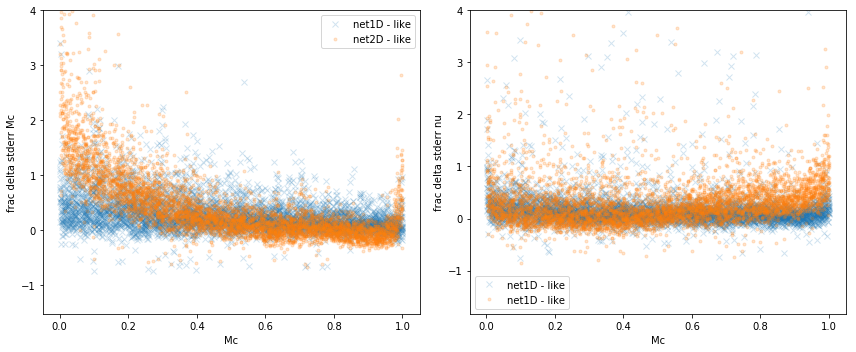

In [0]:
pp.figure(figsize=(12,5))

idx = np.argsort(Mc)

pp.subplot(1,2,1)
pp.plot(Mc[idx], (ne[idx]    - le[idx])/le[idx], 'x', label='net1D - like', alpha=0.2)
pp.plot(Mc[idx], (ne2[idx,0] - le[idx])/le[idx], '.', label='net2D - like', alpha=0.2)
pp.xlabel('Mc'); pp.ylabel('frac delta stderr Mc'); pp.legend(); pp.axis(ymax=4)

pp.subplot(1,2,2)
pp.plot(Mc[idx], (ne_nu[idx] - le_nu[idx])/le_nu[idx], 'x', label='net1D - like', alpha=0.2)
pp.plot(Mc[idx], (ne2[idx,1] - le_nu[idx])/le_nu[idx], '.', label='net1D - like', alpha=0.2)
pp.xlabel('Mc'); pp.ylabel('frac delta stderr nu'); pp.legend(); pp.axis(ymax=4)

pp.tight_layout()

(-0.04893208827291221, 1.0497994266805195, -0.5, 0.5)

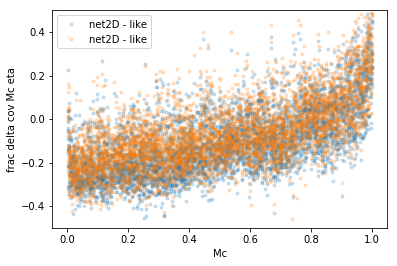

In [0]:
ncov = nc2 / ne2[:,0] / ne2[:,1]
lcov = lc2 / le2[:,0] / le2[:,1]

ncovb = nc2b / ne2b[:,0] / ne2b[:,1]

pp.plot(Mc[idx], ncov[idx] - lcov[idx], '.', label='net2D - like', alpha=0.2)
pp.plot(Mc[idx], ncovb[idx] - lcov[idx], '.', label='net2D - like', alpha=0.2)
pp.xlabel('Mc'); pp.ylabel('frac delta cov Mc eta'); pp.legend(); pp.axis(ymin=-0.5, ymax=0.5)